## Hoverboard Controller Update

We have updated the firmware, the new firmare includes a PID controller.

The hoverboard firmware expects a value between -2000 to 2000 to set the speed of a wheel. Values between -49 and 49 are now accepted.

We can set the PID parameters through the API, the values are integer values

The C code for the PID controller is as follows:

```C
float last_error = 0;
float Kp = -1; // Proportial
float Ki = -1; // Integral
float Kd = -1; // Differential
float Iterm = 0; // Remember Integral of error
const float windup_guard = 1000;

int16_t updatePID(const float desired_val, const float measured_val, const float dt)
{
        float error;
        float delta_error;
        float Dterm;

        if (Kp == -1 || Ki == -1 || Kp == -1)
        {
                // PID values not initialized
                return 0;
        }
        error = desired_val - measured_val;
        delta_error = error - last_error;
        Iterm += error * dt;

        // Prevent I from getting too large
        if (Iterm < - windup_guard)
        {
                Iterm = - windup_guard;
        }
        else if (Iterm > windup_guard)
        {
                Iterm = windup_guard;
        }
        Dterm = 0;
        if (dt > 0)
        {
                Dterm = delta_error / dt;
        }
        // Remember stuff for next calculation
        last_error = error;
        // Compute actual PWM output
        return (int16_t) (Kp*error + Ki*Iterm + Kd*Dterm);
}
```

And it is called in bldc.c after the speed is calculated:

```C
    if(loopCounter < 16000 && inc == 0) // Number of loops with no increment gives time
    {
        loopCounter++;
    }
    else
    {
        if (inc != last_inc)
        {
            last_inc = inc;
            // Wait for direction to be determined in next loop
        }
        else
        {
            // Set and calculate velocity
            // Update realSpeed and PWM
            realSpeed = (float)inc * 16000.0 / (float)loopCounter; // Ticks per Second
            #ifdef MASTER
            SetPWM(updatePID((float)speedM, realSpeed, (float)loopCounter / 16000.0));
            #endif
            #ifdef SLAVE
            SetPWM(updatePID((float)desiredSpeedSlave, realSpeed, (float)loopCounter / 16000.0));
            #endif
            loopCounter = 0;
        }
    }
```    
    

We will rewite the code in Python

In [2]:
class PID(object):
    def __init__(self): 
        self.last_error = 0.
        self.Kp = -1. # Proportial
        self.Ki = -1. # Integral
        self.Kd = -1. # Differential
        self.Iterm = 0. # Remember Integral of error
        self.windup_guard = 1000.
        self.Iterm = 0.

    def updatePID(self, desired_val, measured_val, dt):
        if (self.Kp == -1 or self.Ki == -1 or self.Kp == -1):
            # PID values not initialized
            return 0
            
        error = desired_val - measured_val
        delta_error = error - self.last_error
        self.Iterm += error * dt

        # Prevent I from getting too large
        if (self.Iterm < - self.windup_guard):
            self.Iterm = - self.windup_guard
        else:
            if (self.Iterm > self.windup_guard):
                self.Iterm = self.windup_guard
            
        Dterm = 0
        if (dt > 0):
            Dterm = delta_error / dt
        
        # Remember stuff for next calculation
        self.last_error = error;
        # Compute actual PWM output
        return self.Kp*error + self.Ki*self.Iterm + self.Kd*Dterm

We simulate the hoverboard

We calculate the real speed based on a limited acceleration

We also have to deal with a variable dt (work in progress)

In [3]:
import random
class Hoverboard(object):
    def __init__(self, dt, acc_limit=100.0, noise=False):
        self.last_speed = 0
        self.noise = noise
        self.dt = dt
        self.acc_limit = acc_limit
        self.vel_limit = 1000

    def get_speed(self, desired_speed):
        acc = (desired_speed - self.last_speed) / self.dt
        acc = max(acc, -self.acc_limit)
        acc = min(acc, self.acc_limit)
        speed = self.last_speed + acc * dt
        if self.noise:
            if bool(random.getrandbits(1)):
                speed += 0.025 * pos * random.random()
            else:
                speed -= 0.025 * pos * random.random()
        speed = max(speed, -self.vel_limit)
        speed = min(speed, self.vel_limit)
        self.last_speed = speed
        ### work in progress
        ### calculate dt as a function of speed
        #self.dt = (abs(speed) - 50) + 2
        #self.dt = self.dt / 16000
        return speed, self.dt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [5]:
dt = 1/16000
t_max = 7
x = np.arange(0, t_max, dt)

v_desired = np.zeros_like(x)
v_desired[16000:16000*5] = 100.0

In [44]:
hb = Hoverboard(1/16000, acc_limit=100.)
pid = PID()
pid.Kp = 0.5 # Proportial
pid.Ki = 0.0 # Integral
pid.Kd = 0.0 # Differential
pid.last_error = 0.
v_set = np.zeros_like(x)
for i in range(1, len(v_desired)):
    v_set[i], dt = hb.get_speed(v_desired[i-1])
    v_set[i] = pid.updatePID(v_desired[i-1], v_set[i], dt)

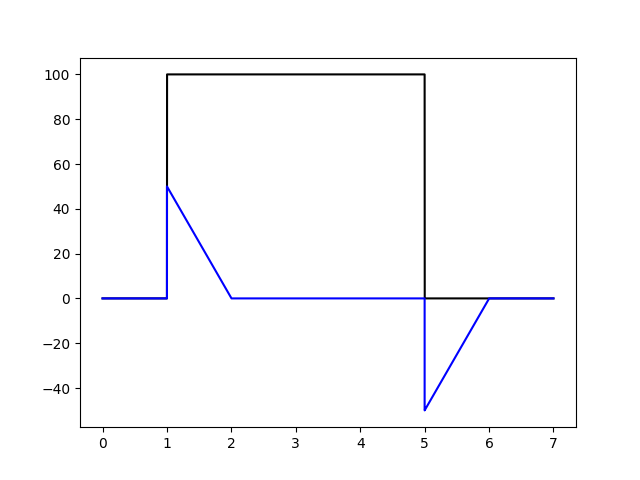

In [45]:
fig, ax = plt.subplots()
ax.plot(x, v_desired, 'k')
ax.plot(x, v_set, 'b')

## Ignore the stuff below
This is taking measurement on the real hoverboard and printing results

In [8]:
arr = np.loadtxt('test-firmware_v2.log')

In [9]:
for i in range(1, len(arr)):
    if arr[i][3] == arr[i-1][3] + 1:
        next
    if arr[i][3] == arr[i-1][3]:
        print("Reading too fast")
    if arr[i][3] > arr[i-1][3] + 1:
        print("Reading too slow")

Reading too slow


In [10]:
#dt = 1/10
#t_max = 7
#x = np.arange(0, t_max, dt)
#v_desired = np.zeros_like(x)
#v_measured = np.zeros_like(x)
#encM = np.zeros_like(x)
#for i in range(len(arr)):
#    v_desired[i] = arr[i][4]
#    encM[i] = arr[i][6] - arr[0][6] + 100
#    v_measured[i] = arr[i][8]

In [11]:
#fig, ax = plt.subplots()
#ax.set_title("Kp: %.1f Ki: %.1f Kd: %.1f" % (arr[0][0]/100, arr[0][1]/100, arr[0][2]/100))
#ax.plot(x[:-1], v_desired[:-1], 'k')
#ax.plot(x[:-1], v_measured[:-1], 'b')
#ax.plot(x[:-1], encM[:-1], 'r')